In [3]:
import jax.numpy as jnp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_device", jax.devices()[2])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel,build_batched_jac_func
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp, get_gaussianRBF
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

# from Optimizers.full_jacobian import CholeskyLM, SVD_LM
# from Optimizers.solvers_base import *

# import Optimizers
# import importlib
# importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM,SketchedLM

import time
from jax.scipy.sparse.linalg import cg
from jax.scipy.linalg import solve,cho_factor,cho_solve

# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from scipy.spatial import distance
from matplotlib import cm
import time
from mpl_toolkits.mplot3d import Axes3D
# from pyDOE import lhs
# #    import sobol_seq
import os
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,
    GP_Sampler_1D_Pinned
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results
plt.style.use("default")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 12
})

## 1.5 Step method

In [94]:
# Sample m training functions as initial conditions from a GP
def get_burgers_data(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    # def func_u0(x):
    #     u0 = 0.25 * (x * np.sin(1 * np.pi*x) - np.sin(5*np.pi*x) - np.sin(3*np.pi*x))
    #     return u0
                            
    
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )
    # # Plot
    # num_fine = 500
    # plt.title("True initial and final")
    # grid_points = jnp.linspace(0,1,num_fine)
    # plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine),grid_points]).T),label = 't=0')
    # plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine),grid_points]).T),label = 't=1')
    # plt.legend()
    # plt.show()

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    # plot_input_data(
    #     tx_obs,
    #     tx_all,
    #     u_true_function,
    #     tx_fine,
    #             )

    return tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp

In [ ]:
tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(gamma=2,n_obs=40,n_coll_t=26, n_coll_x=31, run=0)

In [67]:
# Run 1_5 step method
# u_operators = (eval_k,)
u_operators = (eval_k,dx_k,dt_k)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = OperatorModel(k_P)

[1.55278933 0.13219551]


In [68]:
# # Equation model that has u and P object
# EqnModel = SplitOperatorPDEModel(
#     P_model,
#     (u_model,),
#     (tx_obs,),
#     (u_obs,),
#     (tx_all,),
#     feature_operators,
#     rhs_operator=dt_k,
#     datafit_weight = 100,
#     jacobian_operator = build_batched_jac_func(100),
# )

In [69]:
# Equation model that has u and P object
EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

In [71]:
params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
optparams = LMParams(max_iter = 201)

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    optParams = optparams
)

# p_adjusted,refine_convergence_data = SVD_LM(
#     params,
#     EqnModel,
#     beta = 1e-5,
#     optParams = optparams)
# plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
# plt.yscale('log')
# plt.show()

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.000673, gradnorm = 3.837, alpha = 2.5, improvement_ratio = 1.001
Iteration 1, loss = 0.0004209, gradnorm = 1.728, alpha = 2.083, improvement_ratio = 1.013
Iteration 2, loss = 0.0003288, gradnorm = 0.7979, alpha = 1.736, improvement_ratio = 1.015
Iteration 3, loss = 0.0002884, gradnorm = 0.3837, alpha = 1.447, improvement_ratio = 1.015
Iteration 4, loss = 0.0002662, gradnorm = 0.1924, alpha = 1.206, improvement_ratio = 1.013
Iteration 5, loss = 0.0002513, gradnorm = 0.1018, alpha = 1.005, improvement_ratio = 1.01
Iteration 50, loss = 4.8e-05, gradnorm = 0.01062, alpha = 0.0002747, improvement_ratio = 1.023
Iteration 100, loss = 9.819e-06, gradnorm = 5.285e-05, alpha = 8.333e-07, improvement_ratio = 0.9997
Iteration 150, loss = 8.509e-06, gradnorm = 8.592e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 8.129e-06, gradnorm = 1.252e-06, alpha = 8.333e-07, improvement_ratio = 1.0


In [72]:
u_sol = params[:u_model.num_params]
P_sol = params[u_model.num_params:]

# u_true 
u_true = u_true_function(tx_fine)
# get error
error_u_field = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
error_u_field

Array(0.01173795, dtype=float64)

In [73]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

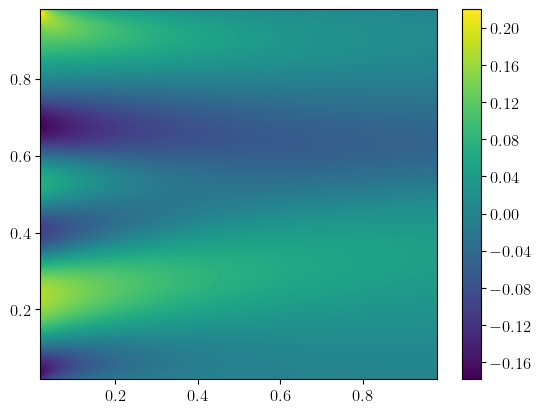

In [74]:
plt.tricontourf(*tx_fine_int.T,ut_true_function(tx_fine_int),200)
plt.colorbar()
plt.show()

In [75]:
# Estimated P from 1.5 step method
input_features = EqnModel.get_stacked_eqn_features((u_sol,)) # before
# input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all) # now
Phat = lambda x: P_model.predict_new(x,input_features,P_sol)

# In-sample

# P[\phi(w)](fine_grid)
def evaluate_Phat(Phat, interp, fine_grid):

    # Build S_test
    def u_true_function(x):
        return interp(x[:,0],x[:,1],grid = False)
    def ux_true_function(x):
        ux_interp = interp.partial_derivative(0,1)
        return ux_interp(x[:,0],x[:,1],grid = False)
    def uxx_true_function(x):
        uxx_interp = interp.partial_derivative(0,2)
        return uxx_interp(x[:,0],x[:,1],grid = False)
    
    # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
    feat_funcs = [u_true_function, ux_true_function, uxx_true_function]
    w_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
    fine_features = jnp.hstack([fine_grid, w_features])
    S_test = fine_features
    
    P_preds = Phat(S_test)
    return P_preds

In [76]:
Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
u_t = ut_true_function(tx_fine_int)

Relative error:  0.12693294484439288


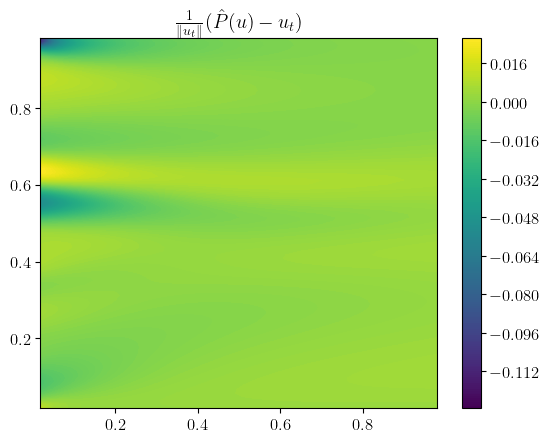

In [77]:
plt.tricontourf(*tx_fine_int.T, (Phat_u - u_t)/ jnp.linalg.norm(u_t),200)
plt.title(r'$\frac{1}{\|u_t\|}(\hat{P}(u)-u_t)$')
plt.tricontourf(*tx_fine_int.T, (Phat_u - u_t),200)
plt.colorbar()
print('Relative error: ',jnp.linalg.norm(Phat_u - u_t,2) / jnp.linalg.norm(u_t,2))
# plt.title(r'$\hat{P}(u)-u_t$')
plt.show()

## Several runs

In [95]:
def get_1_5_error(n_obs,run):
    tx_obs, u_obs, tx_all, tx_int, tx_fine, u_true_function, ut_true_function, interp = get_burgers_data(gamma=2,n_obs=n_obs,n_coll_t=26, n_coll_x=31, run=run)
    # Run 1_5 step method
    # u_operators = (eval_k,)
    u_operators = (eval_k,dx_k,dt_k)
    feature_operators = (eval_k,dx_k,dxx_k)

    # Choose u kernel
    def param_ani_gaussian_RBF(x,y,params):
        lengthscales = log1pexp(params)
        return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

    fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
    ML_lengthscales = log1pexp(fitted_params)
    print(1/(jnp.sqrt(ML_lengthscales)))
    k_u = get_anisotropic_gaussianRBF(0.75,jnp.diag(log1pexp(fitted_params)))

    # RKHS class for u
    u_model = CholInducedRKHS(
        tx_all,
        u_operators,
        k_u,
        nugget_size = 1e-8
        )
    u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

    grid_features_init = (
        (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
        .reshape(
                len(tx_int),
                len(feature_operators),
                order = 'F'
            )
    )

    # Choose kernel for P
    k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')
    @vectorize_kfunc
    def k_P(x,y):
        return k_P_u_part(x[2:],y[2:])
    P_model = OperatorModel(k_P)

    # Equation model that has u and P object
    EqnModel = OperatorPDEModel(
        P_model,
        (u_model,),
        (tx_obs,),
        (u_obs,),
        (tx_int,),
        feature_operators,
        rhs_operator=dt_k,
        datafit_weight = 100
    )
    params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])
    optparams = LMParams(max_iter = 201)

    params,convergence_data = CholeskyLM(
        params_init.copy(),
        EqnModel,
        beta = 1e-11,
        optParams = optparams
    )

    u_sol = params[:u_model.num_params]
    P_sol = params[u_model.num_params:]

    # u_true 
    u_true = u_true_function(tx_fine)
    # get error
    error_u_field = get_nrmse(u_true, u_model.point_evaluate(tx_fine,u_sol))
    
    num_fine_grid = 100
    t_fine,x_fine = np.meshgrid(np.linspace(0,1,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
    tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

    # Estimated P from 1.5 step method
    input_features = EqnModel.get_stacked_eqn_features((u_sol,)) # before
    # input_features = EqnModel.single_eqn_features(u_model,u_sol,tx_all) # now
    Phat = lambda x: P_model.predict_new(x,input_features,P_sol)

    # In-sample

    # P[\phi(w)](fine_grid)
    def evaluate_Phat(Phat, interp, fine_grid):

        # Build S_test
        def u_true_function(x):
            return interp(x[:,0],x[:,1],grid = False)
        def ux_true_function(x):
            ux_interp = interp.partial_derivative(0,1)
            return ux_interp(x[:,0],x[:,1],grid = False)
        def uxx_true_function(x):
            uxx_interp = interp.partial_derivative(0,2)
            return uxx_interp(x[:,0],x[:,1],grid = False)
        
        # By hand since the truth is taken as interp from scipy and not an induced RKHS class where we can apply usual feature operators
        feat_funcs = [u_true_function, ux_true_function, uxx_true_function]
        w_features = jnp.array([feat_func(fine_grid) for feat_func in feat_funcs]).T
        fine_features = jnp.hstack([fine_grid, w_features])
        S_test = fine_features
        
        P_preds = Phat(S_test)
        return P_preds

    Phat_u = evaluate_Phat(Phat, interp, tx_fine_int)
    u_t = ut_true_function(tx_fine_int)

    error_fwd = get_nrmse(u_t, Phat_u)

    return error_u_field, error_fwd

In [96]:
e = {'u': [], 'P':[]}

In [ ]:
for n_obs in [10,20,30,40,50,60,70,80,90]:
    u_errs = []
    P_errs = []
    for run in range(5):
        res = get_1_5_error(n_obs,run)
        u_errs.append(res[0])
        P_errs.append(res[1])
    e['u'].append(u_errs)
    e['P'].append(P_errs)

In [106]:
u_s = jnp.array([jnp.mean(jnp.array(el)) for el in e['u']])
u_stds = jnp.array([jnp.std(jnp.array(el)) for el in e['u']])
P_s = jnp.array([jnp.mean(jnp.array(el)) for el in e['P']])
P_stds = jnp.array([jnp.std(jnp.array(el)) for el in e['P']])

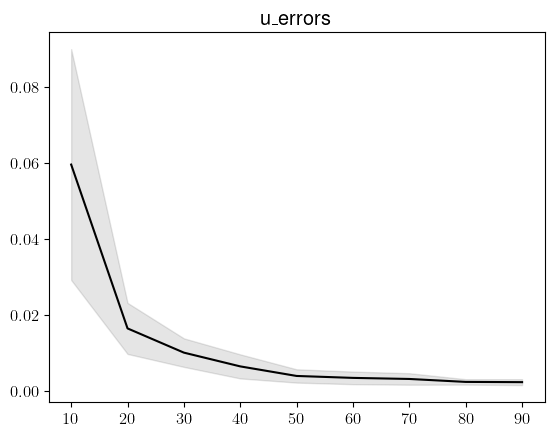

In [107]:
plt.title('u_errors')
plt.plot(jnp.arange(10,100,10),u_s, color = 'black')
plt.fill_between(jnp.arange(10,100,10), u_s - u_stds, u_s + u_stds, alpha=.1, color = 'black')

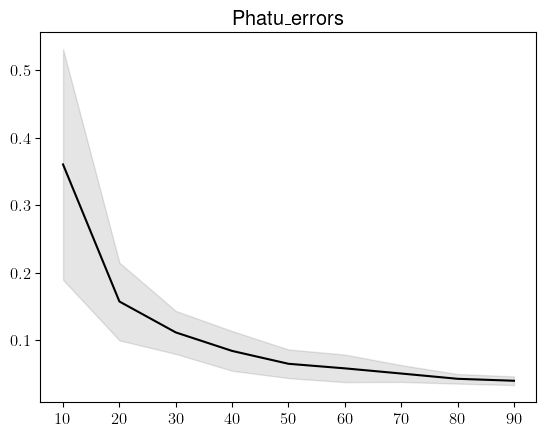

In [111]:
plt.title('Phatu_errors')
plt.plot(jnp.arange(10,100,10),P_s,color = 'black')
plt.fill_between(jnp.arange(10,100,10), P_s - P_stds, P_s + P_stds, alpha=.1, color = 'black')
# plt.yscale('log')

## PINNSR

In [279]:
def get_data_for_pinns(gamma,n_obs, n_coll_t, n_coll_x,run):
    kernel_GP = get_gaussianRBF(0.2)
    xy_pts = jnp.linspace(0,1,50) # Pts to build interpolants
    u0_true_function = GP_Sampler_1D_Pinned(num_samples = 1,
                                            X = xy_pts, 
                                            smooth = gamma,
                                            kernel = kernel_GP,
                                            reg = 1e-8,
                                            seed = run
                                        )
    vec_u0_true_function = np.vectorize(u0_true_function[0])
    
    # Solve m Burgers' equations with IC's: u0_true_functions 
    kappa = 0.01
    alpha = 1.


    u_true_function,ut_true_function, interp,_,_ = (
    build_burgers_data(func_u0=vec_u0_true_function,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
                        )

    # Collocation point set size
    num_grid_x = n_coll_x
    num_grid_t = n_coll_t
    tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x,alpha = 0.5)

    # Collocation point set

    # # Get (X^m, u^m(X^m))
    num_obs = n_obs
    tx_all,tx_obs = setup_problem_data(
        tx_int,
        tx_bdy,
        num_obs,
        jax.random.PRNGKey(run),
        times_to_observe = (0,)
    )

    u_obs = u_true_function(tx_obs)
    t_fine,x_fine = jnp.meshgrid(jnp.linspace(0,1,300),jnp.linspace(0,1,300))
    tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
    plot_input_data(
        tx_obs,
        tx_all,
        u_true_function,
        tx_fine,
                )
    # Invert them to be ready for PINNSR
    
    tx_train = tx_obs
    u_train = u_true_function(tx_train)
    tx_val = jax.random.choice(key = jax.random.PRNGKey(0), a = tx_fine, shape = (int(jnp.ceil(tx_train.shape[0]*(1-0.8)/0.8)),), replace=False)
    plt.scatter(*tx_val.T,c = 'green')
    u_val = u_true_function(tx_val)
    lb = tx_fine.min(0)
    ub = tx_fine.max(0)

    tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

    tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

    tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

    tx_all = jnp.vstack([tx_all,tx_train])

    return [tx_train, u_train, tx_all, tx_val, u_val, lb, ub]

  0%|          | 0/10099 [00:00<?, ?it/s]

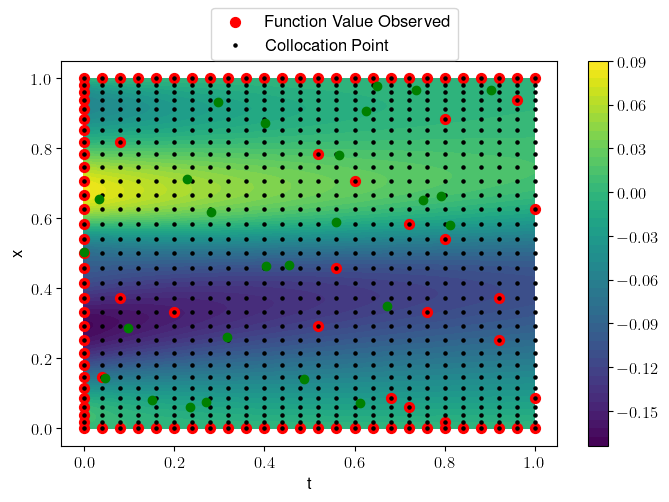

In [280]:
data_pinns = get_data_for_pinns(gamma=2,n_obs=20,n_coll_t=26, n_coll_x=31, run=2)

In [283]:
data_numpy = list(map(np.array,data_pinns))

In [284]:
np.save('data_test_pinn.npy', np.array(data_numpy, dtype=object), allow_pickle=True)

The equation recovered by PINNSR was:
```
u_t = -0.0136393011
-0.33108413u
+0.0043411828u**2
-0.039289325u_x
+0.33696544u*u_x
+0.026660636u**2*u_x
+0.005249514u_xx
-0.00819559u*u_xx
-0.08392856u**2*u_xx
```

In [285]:
# Estimated P
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)
def ux_true_function(x):
    ux_interp = interp.partial_derivative(0,1)
    return ux_interp(x[:,0],x[:,1],grid = False)
def uxx_true_function(x):
    uxx_interp = interp.partial_derivative(0,2)
    return uxx_interp(x[:,0],x[:,1],grid = False)

fine_grid = tx_fine_int
U = u_true_function(fine_grid)
U_x = ux_true_function(fine_grid)
U_xx = uxx_true_function(fine_grid)

Phat_PINNSR = -0.0136393011-0.33108413*U+0.0043411828*jnp.multiply(U,U)-0.039289325*U_x+0.33696544*jnp.multiply(U,U_x)+0.026660636*jnp.multiply(jnp.multiply(U,U),U_x)+0.005249514*U_xx-0.00819559*jnp.multiply(U,U_xx)-0.08392856*jnp.multiply(jnp.multiply(U,U),U_xx)

Relative error:  0.38154099944734315


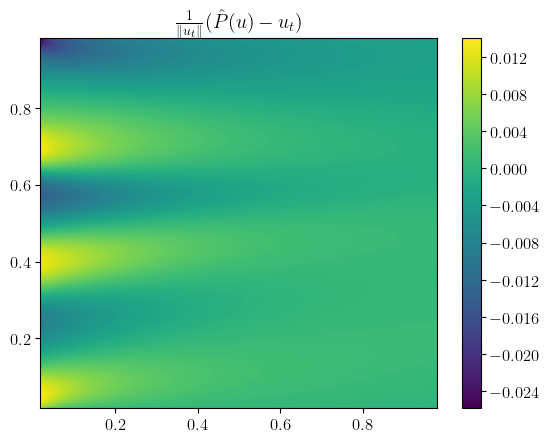

In [286]:
plt.tricontourf(*tx_fine_int.T, (Phat_PINNSR - u_t)/ jnp.linalg.norm(u_t),200)
plt.title(r'$\frac{1}{\|u_t\|}(\hat{P}(u)-u_t)$')
# plt.tricontourf(*tx_test.T, (Phat_PINNSR - u_t),200)
plt.colorbar()
print('Relative error: ',jnp.linalg.norm(Phat_PINNSR - u_t,2) / jnp.linalg.norm(u_t,2))
# plt.title(r'$\hat{P}(u)-u_t$')
plt.show()